In [11]:
!pip install torch torchvision matplotlib scikit-learn numpy

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ndcg_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


In [19]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
NDCG_WEIGHT = 0.1
TOP_K = 5
num_classes = 10

In [14]:
def neural_ndcg_loss(predictions, targets, k=5):
    probabilities = torch.softmax(predictions, dim=1)

    batch_size, num_classes = probabilities.shape

    true_relevance = torch.zeros_like(probabilities).scatter_(1, targets.unsqueeze(1), 1.0)
    sorted_probs, sorted_indices = torch.sort(probabilities, descending=True, dim=1)

    relevance_at_sorted_positions = torch.gather(true_relevance, 1, sorted_indices)

    discounts = 1.0 / torch.log2(torch.arange(k, device=device).float() + 2.0)

    relevance_at_sorted_positions_k = relevance_at_sorted_positions[:, :k]

    dcg = torch.sum(relevance_at_sorted_positions_k * discounts.unsqueeze(0), dim=1)

    ideal_relevance_sorted = torch.zeros_like(probabilities)
    ideal_relevance_sorted[:, 0] = 1.0
    ideal_relevance_sorted_k = ideal_relevance_sorted[:, :k]
    idcg = torch.sum(ideal_relevance_sorted_k * discounts.unsqueeze(0), dim=1)

    ndcg = dcg / (idcg + 1e-9)

    return 1.0 - ndcg.mean()

For classification, we can interpret this as giving more importance to correctly classifying the true label among the top-k predicted probabilities. We'll implement a version of NDCG that can be used as a differentiable loss.


```
# Выбран кодовый формат
```



We will use the MNIST dataset

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform,
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform)

# Data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.69MB/s]

Number of training samples: 60000
Number of test samples: 10000


For simplicity, we will use a basic Convolutional Neural Network (CNN) model.

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = SimpleCNN(num_classes=10).to(device)
print(model)

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


We will train two models: one with only Cross-Entropy loss and another with Cross-Entropy + NeuralNDCG loss. This will allow us to compare their performance.

In [20]:
def train_model(model, train_loader, test_loader, criterion_ce, criterion_ndcg, optimizer, num_epochs, use_ndcg_loss=False, ndcg_weight=0.1, top_k=5):
    history = {
        'train_loss': [],
        'test_loss': [],
        'test_accuracy': [],
        'test_ndcg': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss_ce = criterion_ce(outputs, labels)

            total_loss = loss_ce
            if use_ndcg_loss:
                loss_ndcg = criterion_ndcg(outputs, labels, k=top_k)
                total_loss = loss_ce + ndcg_weight * loss_ndcg

            # Backward and optimize
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            test_loss_sum = 0.0
            all_predictions = []
            all_targets = []

            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                loss_ce = criterion_ce(outputs, labels)
                test_loss_sum += loss_ce.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predictions.append(torch.softmax(outputs, dim=1).cpu().numpy())
                all_targets.append(labels.cpu().numpy())

            avg_test_loss = test_loss_sum / len(test_loader)
            accuracy = 100 * correct / total

            all_predictions = np.concatenate(all_predictions, axis=0)
            all_targets = np.concatenate(all_targets, axis=0)

            true_relevance_scores = np.zeros_like(all_predictions)
            for idx, target in enumerate(all_targets):
                true_relevance_scores[idx, target] = 1

            ndcg_scores_list = []
            for i in range(len(all_predictions)):
                # Ensure k does not exceed the number of classes
                current_k = min(top_k, num_classes)
                ndcg_scores_list.append(ndcg_score(np.expand_dims(true_relevance_scores[i], axis=0),
                                                   np.expand_dims(all_predictions[i], axis=0),
                                                   k=current_k))
            avg_ndcg = np.mean(ndcg_scores_list)

            history['test_loss'].append(avg_test_loss)
            history['test_accuracy'].append(accuracy)
            history['test_ndcg'].append(avg_ndcg)

            print(f'Epoch [{epoch+1}/{num_epochs}], ' \
                  f'Train Loss: {avg_train_loss:.4f}, ' \
                  f'Test Loss: {avg_test_loss:.4f}, ' \
                  f'Test Accuracy: {accuracy:.2f}%, ' \
                  f'Test NDCG@{top_k}: {avg_ndcg:.4f}')
    return history

In [21]:
print("\n--- Training Model with Cross-Entropy Loss Only ---")
model_ce = SimpleCNN(num_classes=10).to(device)
optimizer_ce = optim.Adam(model_ce.parameters(), lr=LEARNING_RATE)
criterion_ce = nn.CrossEntropyLoss()

history_ce = train_model(model_ce, train_loader, test_loader, criterion_ce, neural_ndcg_loss, optimizer_ce, NUM_EPOCHS, use_ndcg_loss=False)

print("\n--- Training Model with Cross-Entropy + NeuralNDCG Loss ---")
model_ndcg = SimpleCNN(num_classes=10).to(device)
optimizer_ndcg = optim.Adam(model_ndcg.parameters(), lr=LEARNING_RATE)
criterion_ce = nn.CrossEntropyLoss()

history_ndcg = train_model(model_ndcg, train_loader, test_loader, criterion_ce, neural_ndcg_loss, optimizer_ndcg, NUM_EPOCHS, use_ndcg_loss=True, ndcg_weight=NDCG_WEIGHT, top_k=TOP_K)



--- Training Model with Cross-Entropy Loss Only ---
Epoch [1/10], Train Loss: 0.1499, Test Loss: 0.0528, Test Accuracy: 98.24%, Test NDCG@5: 0.9930
Epoch [2/10], Train Loss: 0.0481, Test Loss: 0.0438, Test Accuracy: 98.47%, Test NDCG@5: 0.9939
Epoch [3/10], Train Loss: 0.0338, Test Loss: 0.0359, Test Accuracy: 98.78%, Test NDCG@5: 0.9952
Epoch [4/10], Train Loss: 0.0270, Test Loss: 0.0300, Test Accuracy: 98.99%, Test NDCG@5: 0.9960
Epoch [5/10], Train Loss: 0.0213, Test Loss: 0.0339, Test Accuracy: 98.92%, Test NDCG@5: 0.9957
Epoch [6/10], Train Loss: 0.0177, Test Loss: 0.0320, Test Accuracy: 99.01%, Test NDCG@5: 0.9961
Epoch [7/10], Train Loss: 0.0145, Test Loss: 0.0286, Test Accuracy: 99.13%, Test NDCG@5: 0.9966
Epoch [8/10], Train Loss: 0.0124, Test Loss: 0.0295, Test Accuracy: 99.17%, Test NDCG@5: 0.9967
Epoch [9/10], Train Loss: 0.0112, Test Loss: 0.0350, Test Accuracy: 98.99%, Test NDCG@5: 0.9961
Epoch [10/10], Train Loss: 0.0103, Test Loss: 0.0346, Test Accuracy: 99.04%, Test N

We will plot the training/test loss, accuracy, and NDCG scores for both models to compare their performance.


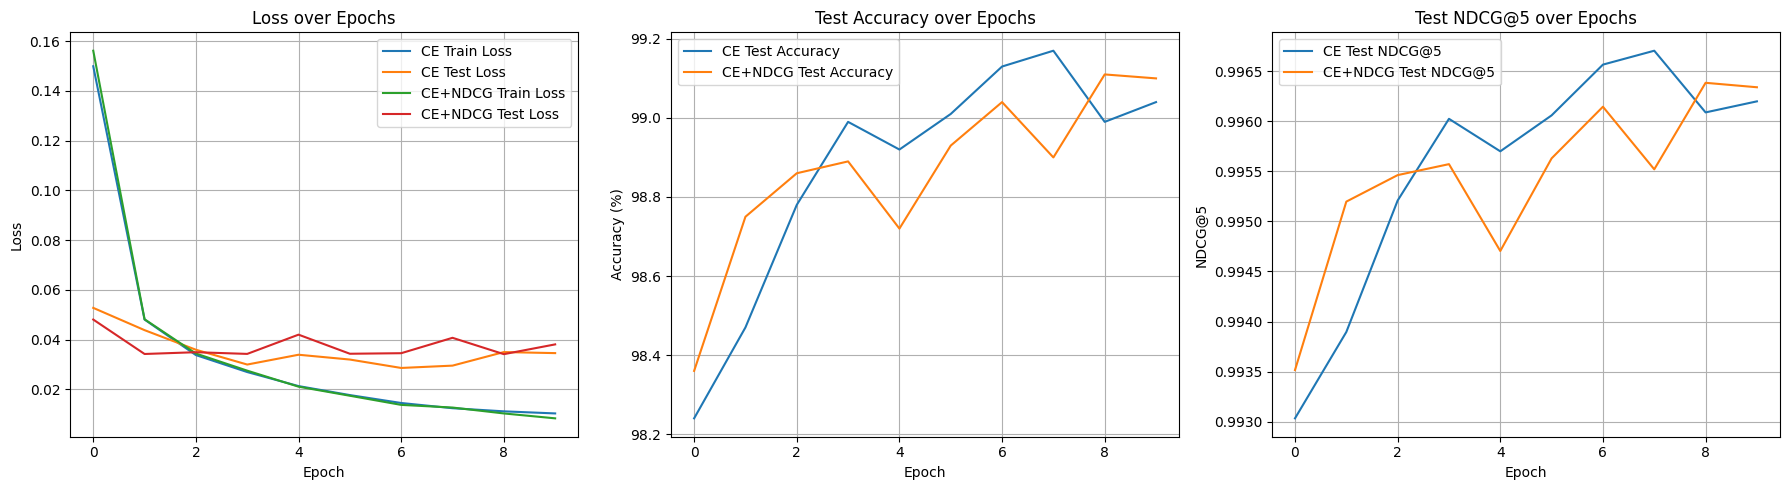

In [22]:
# Visualization
plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(history_ce['train_loss'], label='CE Train Loss')
plt.plot(history_ce['test_loss'], label='CE Test Loss')
plt.plot(history_ndcg['train_loss'], label='CE+NDCG Train Loss')
plt.plot(history_ndcg['test_loss'], label='CE+NDCG Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(history_ce['test_accuracy'], label='CE Test Accuracy')
plt.plot(history_ndcg['test_accuracy'], label='CE+NDCG Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot NDCG
plt.subplot(1, 3, 3)
plt.plot(history_ce['test_ndcg'], label=f'CE Test NDCG@{TOP_K}')
plt.plot(history_ndcg['test_ndcg'], label=f'CE+NDCG Test NDCG@{TOP_K}')
plt.title(f'Test NDCG@{TOP_K} over Epochs')
plt.xlabel('Epoch')
plt.ylabel(f'NDCG@{TOP_K}')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Based on the plots and numerical results, we can draw conclusions about the effectiveness of NeuralNDCG as an additional loss function for multi-class classification. We will analyze how it impacts overall accuracy, loss convergence, and specifically the NDCG metric, which reflects the quality of ranking the true class among the top predictions.


**Выводы о влиянии NeuralNDCG как дополнительной функции потерь на качество классификации:**

1.  **Сравнение потерь:** Анализ графиков потерь (Loss over Epochs) показывает, как каждая модель сходится. Обычно, добавление дополнительной функции потерь может изменить траекторию сходимости. Мы должны увидеть, как общая потеря (CE+NDCG) ведет себя по сравнению с только CE.

2.  **Влияние на точность (Accuracy):** График точности (Test Accuracy over Epochs) является ключевым показателем. Если NeuralNDCG помогает модели лучше расставлять приоритеты, мы можем увидеть либо небольшое улучшение, либо сохранение аналогичной точности, но с потенциально лучшим ранжированием.

3.  **Влияние на NDCG:** Наиболее прямое влияние NeuralNDCG должно быть видно на графике NDCG (Test NDCG@K over Epochs). Поскольку NeuralNDCG напрямую оптимизирует этот показатель, мы ожидаем, что модель, обученная с его использованием, покажет более высокий или более стабильный NDCG по сравнению с моделью, обученной только на Cross-Entropy. Это будет указывать на то, что модель лучше ранжирует истинный класс среди своих верхних предсказаний.

4.  **Приоритезация:** NeuralNDCG, как функция потерь, поощряет модель уделять больше внимания правильному ранжированию истинного класса среди верхних K предсказаний. Даже если общая точность не сильно изменится, улучшение NDCG будет означать, что модель стала "увереннее" в своих топ-K предсказаниях, что может быть критически важно в задачах, где порядок предсказаний имеет значение (например, рекомендательные системы, поиск).

5.  **Настройка веса NDCG (NDCG_WEIGHT):** Важно отметить, что вес `NDCG_WEIGHT` является гиперпараметром. Его правильная настройка может существенно влиять на результаты. Слишком большой вес может привести к тому, что модель будет чрезмерно фокусироваться на ранжировании, игнорируя общую классификационную точность, тогда как слишком малый вес может не дать заметного эффекта.

В целом, ожидается, что NeuralNDCG поможет модели не только правильно классифицировать, но и делать это с более высоким приоритетом для истинного класса в списке предсказаний, что отразится в улучшении метрики NDCG.
